In [36]:
#### right code !!!!
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, zscore, pearsonr

def check_for_nan(array, array_name):
    if np.isnan(array).any():
        print(f"There are NaN values in {array_name}.")
        nan_count = np.isnan(array).sum()
        print(f"Total number of NaN values in {array_name}: {nan_count}")
    else:
        print(f"There are no NaN values in {array_name}.")

def activity_flow_conn(conn_array, func_array):
    
    taskActMatrix = func_array #shape parcel x timeseries x subj
    connMatrix = conn_array # shape parcel x parcel x state x subj

    numTasks = taskActMatrix.shape[1]
    numRegions = taskActMatrix.shape[0]
    numConnStates = connMatrix.shape[2]
    numSubjs = connMatrix.shape[3]

    # Setup for prediction
    taskPredMatrix = np.zeros((numRegions, numTasks, numSubjs))
    taskPredRs = np.zeros((numTasks, numSubjs))
    taskActualMatrix = taskActMatrix
    regionNumList = np.arange(numRegions)

    for subjNum in range(numSubjs):
        for taskNum in range(numTasks):

            # Get this subject's activation pattern for this task
            taskActVect = taskActMatrix[:, taskNum, subjNum]

            for regionNum in range(numRegions):

                # Hold out region whose activity is being predicted
                otherRegions = np.delete(regionNumList, regionNum)

                # Get this region's connectivity pattern
                if numConnStates > 1:
                    stateFCVect = connMatrix[:, regionNum, taskNum, subjNum]
                else:
                    # If using resting-state (or any single state) data
                    stateFCVect = connMatrix[:, regionNum, 0, subjNum]

                # Calculate activity flow prediction
                taskPredMatrix[regionNum, taskNum, subjNum] = np.sum(taskActVect[otherRegions] * stateFCVect[otherRegions])
            # Normalize values (z-score)
            taskPredMatrix[:, taskNum, subjNum] = zscore(taskPredMatrix[:, taskNum, subjNum])
            taskActualMatrix[:, taskNum, subjNum] = zscore(taskActMatrix[:, taskNum, subjNum])

            # Calculate predicted to actual similarity for this task
            pearson_corr = pearsonr(taskPredMatrix[:, taskNum, subjNum], taskActualMatrix[:, taskNum, subjNum])
            spearman_corr, spearman_p_val = spearmanr(taskPredMatrix[:, taskNum, 0], taskActualMatrix[:, taskNum, 0])
        #taskPredRs[taskNum, subjNum] = pearson_corr[0, 1]
    
    return taskPredMatrix, taskActualMatrix, pearson_corr, spearman_corr, spearman_p_val
    
def scatter_plot_func(taskPredMatrix, taskActualMatrix, spearman_corr, spearman_p_val, sub_id=None, save_dir=None):
    
    spearman_corr = float(spearman_corr)
    spearman_p_val = float(spearman_p_val)
    
    pred_values = taskPredMatrix[:, 0, 0]
    actual_values = taskActualMatrix[:, 0, 0]

    plt.figure()
    plt.scatter(range(len(pred_values)), pred_values, color='lightblue', label='Predicted Activation')
    plt.scatter(range(len(actual_values)), actual_values, color='lightcoral', label='Empirical Activation')

    plt.title(f'Predicted vs Empirical Activation for {sub_id}' if sub_id else 'Predicted vs Empirical Activation')
    plt.xlabel('Region')
    plt.ylabel('Activation')

    plt.legend(
        loc='upper left',  # Position inside the plot
        bbox_to_anchor=(1.05, 1),  # Move the legend outside the plot
        borderaxespad=0.,
        title=f"Spearman's $\\rho$: {spearman_corr:.3f} (p={spearman_p_val:.2g})"
    )
    if save_dir and sub_id:
        save_path = f"{save_dir}/scatter_plot_{sub_id}.png"
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    plt.show()
    
    return

def main(input_conn, input_func):

    sub_id = input_conn.split('/')[-3]
    print(sub_id)

    base_name = os.path.basename(input_func)
    condition = base_name.split('_sub')[0]

    conn_array = pd.read_csv(input_conn, delimiter=',', header=None, dtype=float).to_numpy()
    func_array = np.load(input_func)

    func_array = np.expand_dims(func_array, axis=1)
    func_array = np.expand_dims(func_array, axis=2)

    func_arrayy = check_for_nan(func_array, "func_array")

    conn_array = np.expand_dims(conn_array, axis=2)
    conn_array = np.expand_dims(conn_array, axis=3)


    taskPredMatrix, taskActualMatrix, pearson_corr, spearman_corr, spearman_p_val = activity_flow_conn(conn_array, func_array)
    
    os.makedirs(f'derivatives/output_AFM_{condition}', exist_ok=True)
    
    correlations_path = f"derivatives/output_AFM_{condition}/correlations_{sub_id}.txt"

    # Open the file in write mode
    with open(correlations_path, 'w') as f:
        # Write the variables to the file
        f.write(f"pearson_corr: {pearson_corr}\n")
        f.write(f"spearman_corr: {spearman_corr}\n")

    save_dir = f"derivatives/output_AFM_{condition}"

    task_pred_matrix_path = os.path.join(save_dir, f"taskPredMatrix_{sub_id}_{condition}.npy")
    np.save(task_pred_matrix_path, taskPredMatrix)
    
    print(taskPredMatrix.shape)
    
    scatter_plot_func(taskPredMatrix, taskActualMatrix, spearman_corr, spearman_p_val, sub_id, save_dir)

#if __name__ == "__main__":

#    input_conn = sys.argv[1]
#    input_func = sys.argv[2]
#    
#    main(input_conn, input_func)

sub-10189
There are no NaN values in func_array.
(454, 1, 1)
Plot saved to derivatives/output_AFM_low_wm_condition4500/scatter_plot_sub-10189.png


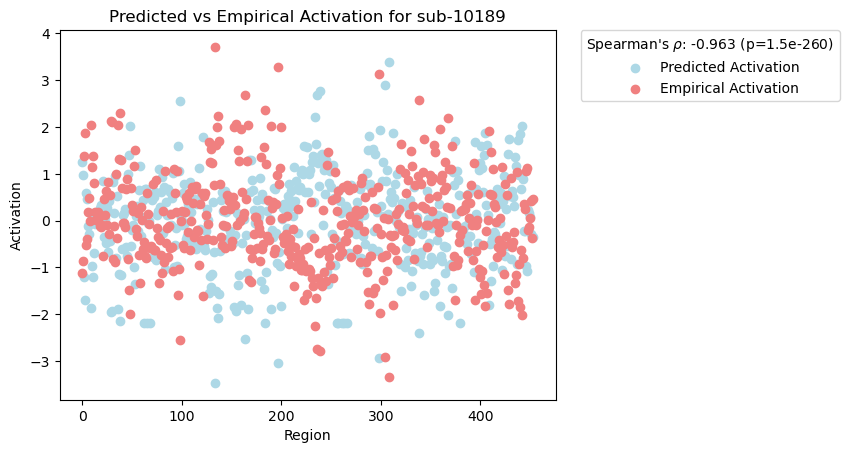

In [37]:
main("/home/gabridele/Desktop/irbio_folder/spreading_dynamics_clinical/derivatives/sub-10189/dwi/full_association_mtrix_sub-10189.csv", "/home/gabridele/Desktop/irbio_folder/spreading_dynamics_clinical/derivatives/sub-10189/func/low_wm_condition4500_sub-10189_2vol_ts_1vol_.npy")

In [26]:
a = "/home/gabridele/Desktop/irbio_folder/spreading_dynamics_clinical/derivatives/sub-10339/func/high_wm_1500_sub-10339_ts_1vol.npy"
b = "/home/gabridele/Desktop/irbio_folder/spreading_dynamics_clinical/derivatives/sub-10339/dwi/full_association_mtrix_sub-10339_30seeds.csv"

In [27]:
import numpy as np
import pandas as pd
b = pd.read_csv(b, header=None)
print(b)

        0       1       2       3       4       5       6       7       8    \
0    0.0000  0.7329  0.2481  0.3619  0.8013  0.7013  0.5529  0.2932  0.2341   
1    0.7329  0.0000  0.2758  0.3138  0.6714  0.6335  0.5478  0.3187  0.3742   
2    0.2481  0.2758  0.0000  0.5799  0.1962  0.1651  0.1279  0.5463  0.4378   
3    0.3619  0.3138  0.5799  0.0000  0.2893  0.2274  0.1450  0.4613  0.3042   
4    0.8013  0.6714  0.1962  0.2893  0.0000  0.8108  0.6176  0.2553  0.1923   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
449  0.0173  0.0168  0.0018  0.0006  0.0263  0.0470  0.1039  0.0108  0.0036   
450  0.0036  0.0045  0.0070  0.0010  0.0079  0.0154  0.0433  0.0285  0.0243   
451  0.0010  0.0023  0.0106  0.0010  0.0023  0.0046  0.0157  0.0350  0.0379   
452  0.0087  0.0093  0.0056  0.0023  0.0133  0.0215  0.0551  0.0231  0.0171   
453  0.0043  0.0060  0.0094  0.0054  0.0052  0.0076  0.0163  0.0355  0.0318   

        9    ...     444     445     446     447   